# Поиск "токсичных" комментариев

## Описание проекта

Интернет-магазин запускает новый сервис, позволяющий пользователям редактировать
и дополнять описание товаров. Клиенты предлагают свои правки и комментируют изменения других.
Необходимо разработать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

## План выполнения проекта:

1. Обзор и подготовка данных:
  *  Удаление не значимых столбцов
  *  Приведение текстов к нижнему регистру
  *  Удаление символов отличных от латинских букв
  *  Лемматизация текстов
  *  Деление на тестовую и обучающую выборку, выделение целевого признака
2. Подбор параметров моделей:
  *  Линейная регрессия
  *  Дерево решений
  *  Случайный лес
  *  Модель градиентного бустинга
3. Обучение модели, показавшей наилучшую метрику на этапе подбора параметров, и расчёт метрики качества на тестовой выборке

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import nltk 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from spellchecker import SpellChecker

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from matplotlib.ticker import FixedLocator, FixedFormatter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Подготовка

In [2]:
data = pd.read_csv('../datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.columns

Index(['Unnamed: 0', 'text', 'toxic'], dtype='object')

Удалим столбец 'Unnamed: 0'

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)
data.columns

Index(['text', 'toxic'], dtype='object')

Приведем все тексты к нижнему регистру, уберем все символы кроме латинских букв и лемматизируем данные

In [5]:
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

def clear_text(text):
  text = re.sub(r'[^a-zA-Z ]', ' ', text) 
  words = text.split() 
  return " ".join(words)

def spell_check(text):
    result = []
    for word in text:
        correct_word = spell.correction(word)
        result.append(correct_word)
    
    return " ".join(result)

def lemmatize_raw_text(text):
    text = text.lower()
    text = clear_text(text)
    
    result = []
    for word in text.split():
        lemma = lemmatizer.lemmatize(word)
        result.append(lemma)
    
    return " ".join(result)

data['text'] = data['text'].str.lower()
data['lemm_text'] = data['text'].apply(
    lambda x: lemmatize_raw_text(x))


Выделим целевой признак. Разобьем данные на тестовую и обучающую выборку.

In [6]:
features = data['lemm_text']
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

In [7]:
stopwords = set(nltk_stopwords.words('english'))
tf_idf_vect = TfidfVectorizer(stop_words=stopwords)

def get_pipeline(model):
    pipeline = Pipeline([
        ('tf_idf', tf_idf_vect),
        ('mod', model)
    ])
    return pipeline

**Вывод** Данные очищены и лемматизированы. Построена матрица значений TF-IDF.

## Обучение

### Логистическая регрессия

Посмотрим баланс классов

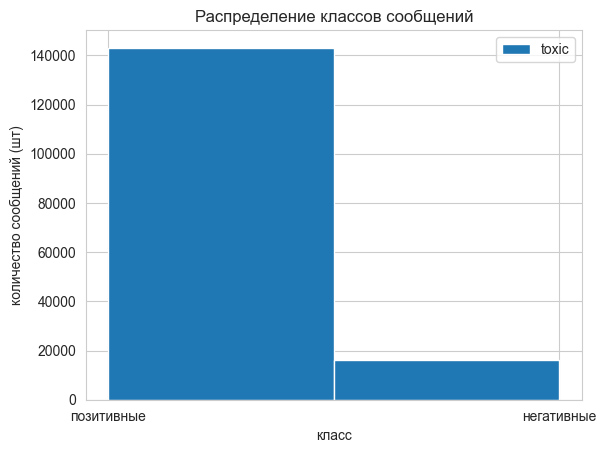

In [8]:
fig, ax = plt.subplots()
data.plot(kind='hist', y='toxic', ax=ax, bins=2)
ax.xaxis.set_major_locator(FixedLocator([0, 1]))
ax.xaxis.set_major_formatter(FixedFormatter(['позитивные', 'негативные']))
plt.title("Распределение классов сообщений", fontsize=12)
plt.xlabel("класс")
plt.ylabel("количество сообщений (шт)")
plt.show()

Классы не сбалансированы, класс 1 встречается рее примерно в 7 раз. Обучим модель задав параметр class_weight='balanced'

In [9]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
pipeline = get_pipeline(model)

mean_f1 = cross_val_score(pipeline, features_train, target_train, scoring='f1', cv=5).mean()
print('Усреднённая f1: ', mean_f1)

Усреднённая f1:  0.742043272829016


Усреднённая метрика f1 для модели логистическая регрессия равна 0.74

### Дерево решений

In [10]:
model = DecisionTreeClassifier(random_state=1234, class_weight='balanced') 
pipeline = get_pipeline(model)

parameters = {'mod__max_depth': range (1, 10, 2), 'mod__criterion': ['gini', 'entropy']}

grid = GridSearchCV(pipeline, parameters, scoring ='f1', cv=3, verbose=10)
grid.fit(features_train, np.array(target_train))

print('Лучшие параметры', grid.best_params_)
print('Усреднённая f1', grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START mod__criterion=gini, mod__max_depth=1......................
[CV 1/3; 1/10] END mod__criterion=gini, mod__max_depth=1;, score=0.270 total time=   3.6s
[CV 2/3; 1/10] START mod__criterion=gini, mod__max_depth=1......................
[CV 2/3; 1/10] END mod__criterion=gini, mod__max_depth=1;, score=0.273 total time=   3.5s
[CV 3/3; 1/10] START mod__criterion=gini, mod__max_depth=1......................
[CV 3/3; 1/10] END mod__criterion=gini, mod__max_depth=1;, score=0.275 total time=   3.5s
[CV 1/3; 2/10] START mod__criterion=gini, mod__max_depth=3......................
[CV 1/3; 2/10] END mod__criterion=gini, mod__max_depth=3;, score=0.370 total time=   4.1s
[CV 2/3; 2/10] START mod__criterion=gini, mod__max_depth=3......................
[CV 2/3; 2/10] END mod__criterion=gini, mod__max_depth=3;, score=0.370 total time=   4.1s
[CV 3/3; 2/10] START mod__criterion=gini, mod__max_depth=3......................
[CV

Лучшие параметры для модели {'criterion': 'entropy', 'max_depth': 9} Усреднённая метрика f1 равна 0.54

### Случайный лес

In [11]:
model = RandomForestClassifier(random_state=1234, class_weight='balanced')
pipeline = get_pipeline(model)

parameters = {'mod__n_estimators': range (50, 110, 10), 'mod__max_depth': range (10, 15, 2)}
grid = GridSearchCV(pipeline, parameters, scoring ='f1', cv=3, verbose=10)
grid.fit(features_train, target_train)

print('Лучшие параметры', grid.best_params_)
print('f1', grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START mod__max_depth=10, mod__n_estimators=50....................
[CV 1/3; 1/18] END mod__max_depth=10, mod__n_estimators=50;, score=0.346 total time=   5.1s
[CV 2/3; 1/18] START mod__max_depth=10, mod__n_estimators=50....................
[CV 2/3; 1/18] END mod__max_depth=10, mod__n_estimators=50;, score=0.349 total time=   5.2s
[CV 3/3; 1/18] START mod__max_depth=10, mod__n_estimators=50....................
[CV 3/3; 1/18] END mod__max_depth=10, mod__n_estimators=50;, score=0.354 total time=   5.0s
[CV 1/3; 2/18] START mod__max_depth=10, mod__n_estimators=60....................
[CV 1/3; 2/18] END mod__max_depth=10, mod__n_estimators=60;, score=0.346 total time=   5.2s
[CV 2/3; 2/18] START mod__max_depth=10, mod__n_estimators=60....................
[CV 2/3; 2/18] END mod__max_depth=10, mod__n_estimators=60;, score=0.346 total time=   5.7s
[CV 3/3; 2/18] START mod__max_depth=10, mod__n_estimators=60..............

Лучшие параметры для модели 'max_depth': 14, 'n_estimators': 90. Усреднённая метрика f1 равна 0.38

### Градиентный бустинг

In [12]:
model = LGBMClassifier(random_state = 12345, max_depth=15)
pipeline = get_pipeline(model)

parameters = {
    'mod__n_estimators': (100, 150),
    'mod__learning_rate': (0.1, 0.3)}

grid_lgbm = GridSearchCV(estimator = pipeline, param_grid = parameters, n_jobs = 3, scoring ='f1', cv=2, verbose=20)
grid_lgbm.fit(features_train, target_train)
print(grid_lgbm.best_params_)
print('f1', grid_lgbm.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
{'mod__learning_rate': 0.3, 'mod__n_estimators': 150}
f1 0.750394852862018


Лучшие параметры для модели Градиентный бустинг ('n_estimators': 150, , max_depth=15, 'learning_rate': 0.3). Усреднённая метрика f1 равна 0.75

**Вывод:**
* Модель Градиентный бустинг('max_depth': 15, 'learning_rate': 0.3) f1=0.75 показала наилучший результат f1=0.75
* На втором месте модель логистическая регрессия f1=0.74
* На третьем месте модель Дерево решений ('criterion': 'entropy', 'max_depth': 9) f1=0.55
* Модель Случайный лес показала самый плохой результат f1=0.35

## Тестирование

In [13]:
model = LGBMClassifier(random_state=1234, class_weight='balanced',n_estimators=150, max_depth=15, learning_rate=0.3 )
pipeline = get_pipeline(model)
pipeline.fit(features_train, target_train)

predictions = pipeline.predict(features_test)
accuracy = accuracy_score(predictions, target_test)
score = f1_score(predictions, target_test)
print("accuracy:", accuracy)
print('f1: ', score)

accuracy: 0.9480953217989604
f1:  0.7627138101251291


Метрика f1 на тестовых данных для модели Градиентный бустинг('n_estimators'=150, 'max_depth': 15, 'learning_rate': 0.3) равна 0.75

## Общий вывод

В процессе подготовки данных была проделана следующая работа:
* удалён не значимый столбец
* данные очищены и лемматизированы
* построена матрица значений TF-IDF
* выявлен дисбаланс классов

Были рассмотрены 4 модели машинного обучения: логистическая регрессия, дерево решений, случайный лес, градиентный бустинг. При подборе параметров лучшее значение усредненной f1 показала модель градиентный бустинг ('n_estimators': 150, , max_depth=15, 'learning_rate': 0.3) (0.75). При тестировании данной модели метрика f1 = 0.75.